<a href="https://colab.research.google.com/github/srdg/bangla-dl/blob/master/PyTorch_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Acquisition
Download the [CMATERdb](https://www.dropbox.com/s/55bhfr3ycvsewsi/CMATERdb%203.1.2.rar) pattern recognition database and clean up `/content` directory.

In [1]:
!wget --quiet -O database.rar https://www.dropbox.com/s/55bhfr3ycvsewsi/CMATERdb%203.1.2.rar
!unrar x database.rar > /dev/null
!rm -rf database.rar sample_data
!mv BasicFinalDatabase/ data/

# Imports
Import necessary libaries.  
We use `os` for listing files, `albumentations`, `numpy` and `PIL` for image processing, and `matplotlib` to display a subset of the images.

In [176]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from PIL import Image
import albumentations as A

import torch
from torch.utils.data import Dataset, DataLoader



# Exploratory Data Analysis
Let us see how many distinct classes we have. From the data it is already ascertained that we are working with `.bmp` images, which are bitmap images. Let us see how the images are defined in the dataset.

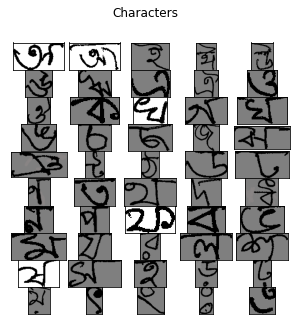

In [15]:
imgs = []
for folder in sorted(os.listdir('data/Train')):
  imgs.append('data/Train/'+folder+'/bcc000000.bmp')

%matplotlib inline
fig = plt.figure(figsize=(5,5))
fig.suptitle('Characters')
for idx in range(50):
    image = Image.open(imgs[idx])
    image = np.array(image)
    # image = np.array(image)[...,0] # comment prev. line and uncomment this to view a single layer
    plt.subplot(10,5,idx+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image, vmin=0, vmax=255)
    # plt.imshow(image, cmap='gray') # comment prev. line and uncomment this to view a single layer
    plt.subplots_adjust(hspace=0, wspace=0)
    
plt.show()

## Checking image-specific details
Looks like all images do not have the same dimensions. Let us see how many of them are unique and see a sample dimension.

In [4]:
img_dims, files = [], []
for folder in sorted(os.listdir('data/Train')):
  tmp = ['data/Train/'+folder+'/'+i for i in sorted(os.listdir('data/Train/'+folder))]
  for i in tmp:
    files.append(i)
img_dims = [np.array(Image.open(i)).shape for i in files]
print("Among", len(img_dims), "images, there are", len(set(img_dims)), "unique dimensions.")
print("Sample dimension:", img_dims[0])

Out of 12000 images, 4879 have unique dimensions.
Sample dimension:  (53, 98, 3)


### How does the image look in each layer?
It is a bitmap image with 3 layers. Let us look at each layer in a sample image individually and plot them to see if we can identify any discernible changes.

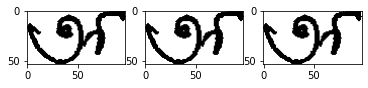

In [5]:
f=files[0]
a=np.array(Image.open(f))
for i in range(a.shape[-1]):
  plt.subplot(1,3,i+1)
  plt.imshow(a[...,i], cmap='gray') # cmap has to be mentioned else plt will map with 'viridis' cmap

Interestingly, we see that there is no change in the image in each layer, it is simply stacked up! Maybe we can use a single layer to train a network in this case.

# Labels
Define our labels in Unicode (UTF-8). We associate each directory with a class.

In [6]:
labels = {
    172:"\u0985",
    173:"\u0986",
    174:"\u0987",
    175:"\u0988",
    176:"\u0989",
    177:"\u098a",
    178:"\u098b",
    179:"\u098f",
    180:"\u0990",
    181:"\u0993",
    182:"\u0994",
    183:"\u0995",
    184:"\u0996",
    185:"\u0997",
    186:"\u0998",
    187:"\u0999",
    188:"\u099a",
    189:"\u099b",
    190:"\u099c",
    191:"\u099d",
    192:"\u099e",
    193:"\u099f",
    194:"\u09a0",
    195:"\u09a1",
    196:"\u09a2",
    197:"\u09a3",
    198:"\u09a4",
    199:"\u09a5",
    200:"\u09a6",
    201:"\u09a7",
    202:"\u09a8",
    203:"\u09aa",
    204:"\u09ab",
    205:"\u09ac",
    206:"\u09ad",
    207:"\u09ae",
    208:"\u09af",
    209:"\u09b0",
    210:"\u09b2",
    211:"\u09b6",
    212:"\u09b7",
    213:"\u09b8",
    214:"\u09b9",
    215:"\u09dc",
    216:"\u09dd",
    217:"\u09df",
    218:"\u09ce",
    219:"\u0982",
    220:"\u0983",
    221:"\u0981",
    }
print("Classes to train:", end=" ")
for i in list(labels.keys()):
  print(labels[i], end=" ")
print()
print("Number of distinct classes:", len(list(labels.keys())))

Classes to train: অ আ ই ঈ উ ঊ ঋ এ ঐ ও ঔ ক খ গ ঘ ঙ চ ছ জ ঝ ঞ ট ঠ ড ঢ ণ ত থ দ ধ ন প ফ ব ভ ম য র ল শ ষ স হ ড় ঢ় য় ৎ ং ঃ ঁ 
Number of distinct classes: 50


# Preparing file lists
We define the list of files to be used for training and testing.

In [99]:
train_files, test_files = [], []

for mode in ['Train', 'Test']:
  for folder in sorted(os.listdir('data/'+mode)):
    tmp = ['data/'+mode+'/'+folder+'/'+i for i in sorted(os.listdir('data/'+mode+'/'+folder))]
    for i in tmp:
      if 'Train' in mode:
        train_files.append(i)
      else:
        test_files.append(i)

In [148]:
class CharacterDataSet(Dataset):

  def __init__(self, files, transform=None):
    self.files = files
    self.transform = transform

  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):
    image = Image.open(files[idx])
    label = int(files[idx].split('/')[2]) # data/Train/172/bcc000000.bmp --> class 172
    image = np.array(image)[...,0]
    if self.transform:
      image = self.transform(image=image)["image"]
      # image = cv.threshold(image, 250, 255, cv.THRESH_BINARY)[1] # manual transform (binary thresholding)
    sample = (image, label)
    return sample

In [149]:
transforms = A.Compose([A.Resize(32,32)])
training_data = CharacterDataSet(train_files, transform=transforms)
testing_data = CharacterDataSet(test_files, transform=transforms)

In [150]:
batch_size = 64
# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=batch_size, shuffle=True)

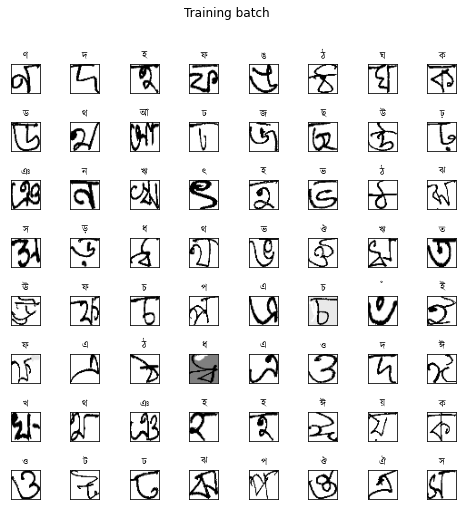

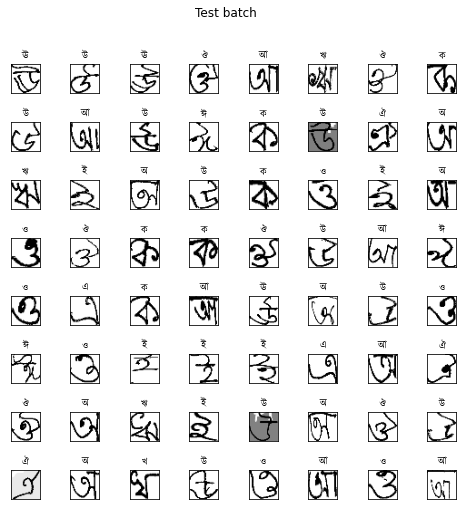

In [183]:
!wget --quiet https://www.omicronlab.com/download/fonts/kalpurush.ttf
%matplotlib inline
prop = fm.FontProperties(fname='kalpurush.ttf')
fig_idx=1
for loader in [train_dataloader, test_dataloader]:
  fig = plt.figure(fig_idx, figsize=(8,8))
  fig.suptitle('Training batch' if fig_idx is 1 else 'Test batch')
  fig_idx+=1
  x,y=None,None
  for X, Y in loader:
    x=X
    y=Y
    break
  for i in range(64):
    plt.subplot(8,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.subplots_adjust(hspace=1, wspace=1)
    plt.title(labels[y[i].numpy().tolist()], fontproperties=prop)
    plt.imshow(x[i], cmap='gray')
  plt.show()